### Stock Market Prediction And Forecasting Using Stacked LSTM

In [ ]:
### Keras and Tensorflow >2.0

In [ ]:
### Data Collection
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 6.3 MB 12.5 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=691e59b4f231a3b310063376a35e0632dbcccea3fc6a56792d428b7188aa414c
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
IBM = yf.Ticker('IBM')
IBM_hist=IBM.history(interval='1d',start='2015-01-01',end='2020-12-31')
IBM_hist.to_csv('IBM.csv')

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df=pd.read_csv('IBM.csv',delimiter=',',usecols=['Date','Open','High','Low','Close'])

In [ ]:
df.head()

,Date,Open,High,Low,Close
0,2015-01-02,122.628159,124.148563,122.392499,123.198311
1,2015-01-05,122.597743,122.597743,121.016522,121.259781
2,2015-01-06,121.381403,121.601868,117.960495,118.644684
3,2015-01-07,119.503722,119.503722,117.093884,117.869293
4,2015-01-08,118.773918,120.902474,118.249377,120.431152


In [ ]:
df.tail()

,Date,Open,High,Low,Close
1505,2020-12-23,120.895646,122.193608,120.759020,120.915169
1506,2020-12-24,121.988664,122.086253,121.217695,121.686134
1507,2020-12-28,122.086257,123.550121,121.461676,121.813004
1508,2020-12-29,122.330236,122.457109,120.271067,120.817581
1509,2020-12-30,120.817582,121.842282,120.651672,121.344566


In [ ]:
df1=df.reset_index()['Close']

In [ ]:
df1.head()

0    123.198311
1    121.259781
2    118.644684
3    117.869293
4    120.431152
Name: Close, dtype: float64

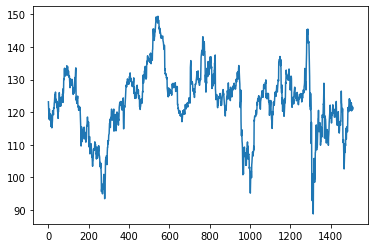

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
print(df1)

[[0.56718273]
 [0.53522275]
 [0.4921084 ]
 ...
 [0.54434357]
 [0.52793233]
 [0.53662058]]


In [ ]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size,test_size

(1057, 453)

In [ ]:
train_data

array([[0.56718273],
       [0.53522275],
       [0.4921084 ],
       ...,
       [0.58092572],
       [0.58431999],
       [0.59376508]])

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   150 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 150
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(906, 150)
(906,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(302, 150)
(302,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(150,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.5.0'

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

123.00273865323963

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

118.93612138588901

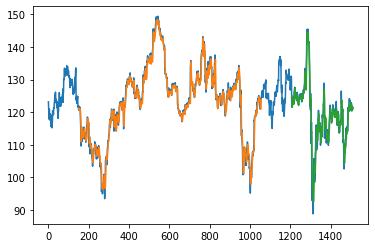

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=150
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

453

In [ ]:
x_input=test_data[302:].reshape(1,-1)
x_input.shape

(1, 151)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=150
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.49130628 0.49114968 0.50852631 0.55627289 0.55376803 0.60339306
 0.66115881 0.60041841 0.56910948 0.3834462  0.44449905 0.44042882
 0.49521978 0.47956538 0.47972186 0.45326554 0.43134913 0.40536261
 0.35855525 0.39941367 0.37060935 0.41068514 0.42665262 0.39174314
 0.40990239 0.41757318 0.37671464 0.37874969 0.34744064 0.3887686
 0.402075   0.42399141 0.4615626  0.47737373 0.49459363 0.51431864
 0.50946541 0.55032408 0.52934676 0.50523882 0.51181366 0.48457471
 0.49788124 0.45999723 0.46062325 0.48206999 0.50602145 0.49991617
 0.51040488 0.51785882 0.55195675 0.54624743 0.54545436 0.51896899
 0.52277532 0.50961182 0.51722437 0.50009616 0.48915299 0.4893116
 0.52927771 0.51278383 0.50532964 0.51294232 0.51960331 0.49169042
 0.49311794 0.56892659 0.50977043 0.47567251 0.45838543 0.47503805
 0.44807659 0.46235026 0.47234176 0.47789271 0.50612283 0.51722437
 0.48296783 0.44316033 0.44728377 0.42063966 0.40890354 0.42254289
 0.46663244 0.45410351 0.46568088 0.45648233 0.44823

In [ ]:
day_new=np.arange(1,151)
day_pred=np.arange(151,181)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(df1)

1510

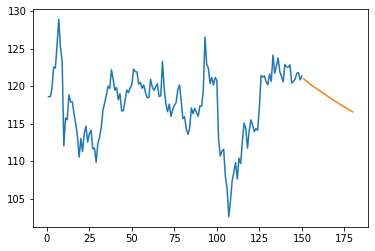

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1360:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

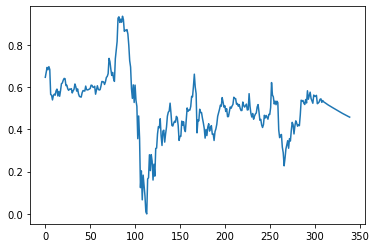

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

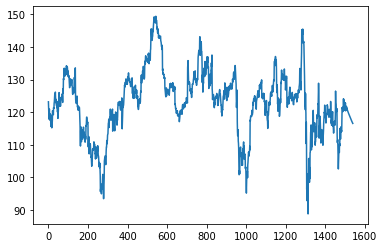

In [ ]:
plt.plot(df3)

###Multivariate LSTM Implementation

In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 6.3 MB 6.4 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=7677211aa0c81806f0de55424447f0dea7f06b4bfb39ffbc8ab93a3aa40bc594
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
tickers=["XOM","BAC","IBM","PFE","TSLA"]
number_of_symbols = len(tickers)
Stocks_hist=yf.download(tickers,interval='1d',start='2015-01-01',end='2020-12-31', auto_adjust=True, group_by='ticker',index=False)
Stocks_hist = Stocks_hist.stack(level=0).rename_axis(['Date', 'Index']).reset_index(level=1)
Stocks_hist.to_csv('StockPrices.csv')
price_data_frame = pd.read_csv('StockPrices.csv',delimiter=',')
print('Loaded data from the Stocks repository')

# Print the head.
print(price_data_frame.head())


[*********************100%***********************]  5 of 5 completed
Loaded data from the Stocks repository
         Date Index       Close        High         Low        Open    Volume
0  2015-01-02   BAC   15.880880   15.996217   15.685697   15.960728  48951100
1  2015-01-02   IBM  121.796097  122.735534  120.999456  121.232435   5525500
2  2015-01-02   PFE   23.154585   23.487159   23.073289   23.110243  16371571
3  2015-01-02  TSLA   43.862000   44.650002   42.652000   44.574001  23822000
4  2015-01-02   XOM   67.654991   67.815329   66.911607   67.232283  10220400


In [4]:


#Read the csv file
df = pd.read_csv('StockPrices.csv')
print(df.head()) #7 columns, including the Date. 

#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

#Variables for training
cols = list(df)[2:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close']

#New dataframe with only training data - 4 columns
df_for_training = df[cols].astype(float)

# df_for_plot=df_for_training.tail(5000)
# df_for_plot.plot.line()

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


         Date Index       Close        High         Low        Open    Volume
0  2015-01-02   BAC   15.880880   15.996217   15.685697   15.960728  48951100
1  2015-01-02   IBM  121.796097  122.735534  120.999456  121.232435   5525500
2  2015-01-02   PFE   23.154585   23.487159   23.073289   23.110243  16371571
3  2015-01-02  TSLA   43.862000   44.650002   42.652000   44.574001  23822000
4  2015-01-02   XOM   67.654991   67.815329   66.911607   67.232283  10220400
7535   2020-12-28
7536   2020-12-28
7537   2020-12-28
7538   2020-12-28
7539   2020-12-28
7540   2020-12-29
7541   2020-12-29
7542   2020-12-29
7543   2020-12-29
7544   2020-12-29
7545   2020-12-30
7546   2020-12-30
7547   2020-12-30
7548   2020-12-30
7549   2020-12-30
Name: Date, dtype: datetime64[ns]
['Close', 'High', 'Low', 'Open']
trainX shape == (7536, 14, 4).
trainY shape == (7536, 1).


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
424/424 [==============================] - 34s 70ms/step - loss: 0.1571 - val_loss: 5.5287
Epoch 2/5
424/424 [==============================] - 30s 70ms/step - loss: 0.0226 - val_loss: 4.3502
Epoch 3/5
424/424 [=============================

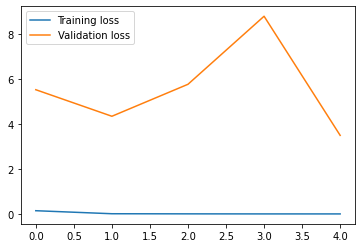

In [5]:

#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [6]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)



[Timestamp('2020-12-24 00:00:00', freq='C'), Timestamp('2020-12-28 00:00:00', freq='C'), Timestamp('2020-12-29 00:00:00', freq='C'), Timestamp('2020-12-30 00:00:00', freq='C'), Timestamp('2020-12-31 00:00:00', freq='C'), Timestamp('2021-01-04 00:00:00', freq='C'), Timestamp('2021-01-05 00:00:00', freq='C'), Timestamp('2021-01-06 00:00:00', freq='C'), Timestamp('2021-01-07 00:00:00', freq='C'), Timestamp('2021-01-08 00:00:00', freq='C'), Timestamp('2021-01-11 00:00:00', freq='C'), Timestamp('2021-01-12 00:00:00', freq='C'), Timestamp('2021-01-13 00:00:00', freq='C'), Timestamp('2021-01-14 00:00:00', freq='C'), Timestamp('2021-01-15 00:00:00', freq='C')]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


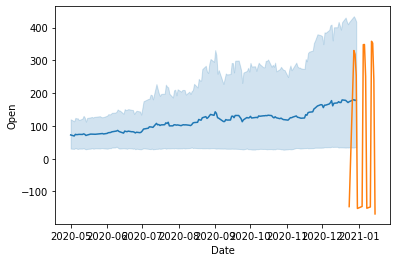

In [7]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])

## Optimize Function Using SciPy


We run the optimization using the scipy.optimization module. This module has a function called minimize which we can use to help our optimial values. However, we need to do a few things before we run it. First, we need to define bounds which tells the minimize function that each of our positions can only be between 0% and 100% of the allocation. Second, we need to define the constraint which will be a function that ensures the sum of the weights is 100%. In other words, we use all the capital we can. Third, we need to define our initial guess of the weights. The initial guess can be anything but in this case we start with an equally distirbuted portofolio. We have 5 symbols so each symbol will be 20% of the portfolio.

In [ ]:
# Calculate the Log of returns.
log_return = np.log(1 + predicted_prices.pct_change())

# Generate Random Weights.
random_weights = np.array(np.random.random(number_of_symbols))

# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)

In [ ]:
def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
        and a sharpe ratio.
    """

    # Convert to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, remember to annualize them (252).
    ret = np.sum(log_return.mean() * weights) * 252

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[2] - 1

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1

Once we've define these steps we can run the optimization by passing through the arguments defined and using the method as SLSQP which is short for Sequential Least Squares Programming. Then we run the minimize method to grab the results.

In [ ]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)

The first is the results of our minimization operation. Inside the results, there is the optimize sharpe ration defined by the fun value. We can then take the optimized_weights defined in the optimized_sharpe.x values, and use them to return the different metrics we have for our portfolio.

In [ ]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)

In [ ]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_volatility = sci_opt.minimize(
    grab_volatility, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED VOLATILITY RATIO:')
print('-'*80)
print(optimized_volatility)
print('-'*80)

In [ ]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_volatility.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)